# **Codificación Huffman | Implementación y experimentos**


Aqui irá una breve introducción al cuaderno de juppyter, aqui hablaré un poco sobre cómo estará estructurado el notebook y qué cosas contiene, probablemente tambien un indice de contenido.

Adicional a ello también voy a proporcionar detalles de cómo funciona el encoder y cómo están hechos los experimentos. Ahora lo demás de esta celda es texto de relleno para ver cómo se ve lleno de texto.

Este es un texto de relleno, un párrafo de relleno que permite ver cómo se ve la celda con bastante texto

### Configuración de rutas

In [ ]:
import os
import pickle
import sys
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 
import string 
# Aqui se añade la carpeta root del proyecto, ya que se esta trabajando en notebook/
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

### Definición de la función que usa el motor de encoding y analiza los resultados

In [ ]:
from encoder.compressor_huffman import CompresorHuffman

def analizar_compresion(ruta_archivo):
    """
    Toma la ruta de un archivo, lo comprime con Huffman y devuelve
    un diccionario con las estadísticas del proceso.
    """
    compresor = CompresorHuffman()
    
    # Manejo de excepción, por si no encuentra el archivo
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as f:
            texto = f.read()
        # Se obtiene el tamaño del archivo antes de la compresión
        tamano_original_bytes = os.path.getsize(ruta_archivo)
    except FileNotFoundError:
        print(f"Error: El archivo {ruta_archivo} no fue encontrado.")
        return None

    # Se realiza la compresión
    texto_comprimido, raiz = compresor.compresion_huffman(texto)

    # Aqui se calcula el tamaño de los archivos para el posterior analisis
    longitud_en_bits = len(texto_comprimido)
    tamano_datos_comprimidos_bytes = (longitud_en_bits + 7) // 8
    
    arbol_serializado = pickle.dumps(raiz)
    tamano_arbol_bytes = len(arbol_serializado)
    
    tamano_total_comprimido_bytes = tamano_datos_comprimidos_bytes + tamano_arbol_bytes
    
    # Se calcula el ratio  = tamaño despues / tamaño antes
    if tamano_original_bytes > 0:
        ratio_compresion = (1 - (tamano_total_comprimido_bytes / tamano_original_bytes)) * 100
    else:
        ratio_compresion = 0

    """
    Se devuelven los resultados para la comprensi[on en forma de diccionario.
    Esto para su posterior analisis
    """
    return {
        "archivo": os.path.basename(ruta_archivo),
        "original_b": tamano_original_bytes,
        "total_comprimido_b": tamano_total_comprimido_bytes,
        "ratio_%": ratio_compresion
    }


### Definicion de la función *obtener_resultados()* en la que se definen los archivos y se obtienen los resultados

In [ ]:
def obtener_resultados(archivos_a_probar):
    """
    aqui se definen los archivos y se obtienen los resultados.
    """
    # Lista de archivos para los exp

    lista_de_resultados = []
    
    for archivo in archivos_a_probar:
        resultado = analizar_compresion(archivo)
        if resultado:
            lista_de_resultados.append(resultado)


    # Resumen
    print("\n" + "="*60)
    print("Resumen de Resultados de Compresión Huffman")
    print("="*60)
    print(f"{'Archivo':<25} | {'Original (B)':>12} | {'Comprimido (B)':>15} | {'Ratio (%)':>10}")
    print("-"*60)
    
    for res in lista_de_resultados:
        print(f"{res['archivo']:<25} | {res['original_b']:>12} | {res['total_comprimido_b']:>15} | {res['ratio_%']:>9.2f}%")
        
    print("="*60)

    return lista_de_resultados
    
# Ejemplo del formato que debe seguir la lista de archivos a probar:
archivos_a_probar = [
        '../data/quijote.txt',
        '../data/texto_repetitivo.txt',
        '../data/texto_aleatorio.txt'
    ]

### Definicion de la función para crear gráficos

In [ ]:
def crear_grafico_comparativo(resultados):
    """
    Crea un gráfico de barras agrupadas comparando el tamaño
    original vs el comprimido para cada archivo.
    """
    # Extraer los datos para graficar
    nombres_archivos = [res['archivo'] for res in resultados]
    tamanos_originales = [res['original_b'] for res in resultados]
    tamanos_comprimidos = [res['total_comprimido_b'] for res in resultados]
    
    # Configuración del gráfico
    x = np.arange(len(nombres_archivos))  # las etiquetas ubicaciones
    ancho_barra = 0.35  # ancho de barras

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # crear las barras
    rects1 = ax.bar(x - ancho_barra/2, tamanos_originales, ancho_barra, label='Original', color='#4c72b0')
    rects2 = ax.bar(x + ancho_barra/2, tamanos_comprimidos, ancho_barra, label='Comprimido', color='#c44e52')

    # Aanadir títulos y etiquetas
    ax.set_title('Comparación de Tamaño: Original vs. Comprimido', fontsize=16, weight='bold')
    ax.set_ylabel('Tamaño (bytes)', fontsize=12)
    ax.set_xlabel('Archivos de Prueba', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(nombres_archivos, rotation=15, ha="right")
    ax.legend()

    # añadir etiquetas de valor sobre las barras para mayor claridad
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    plt.tight_layout()

    if not os.path.exists('../results'):
        os.makedirs('results')
    plt.savefig('../results/grafico_comparativo_tamanos.png')
    plt.show()


In [ ]:
def preparar_datos_escalabilidad(tipo='normal', tamaños_kb=[1, 5, 10, 20, 50]):
    """
    Genera archivos de prueba de diferentes tamaños para un tipo de texto específico.
    Tipos: 'normal', 'repetitivo', 'aleatorio'
    """
    # Cargar el texto base
    if tipo == 'normal':
        with open('../data/quijote.txt', 'r', encoding='utf-8') as f:
            texto_base = f.read()
    elif tipo == 'repetitivo':
        texto_base = "abcde" * 20000 # ~100KB de texto repetitivo
    else: # aleatorio
        texto_base = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(100 * 1024))

    # Crear sub-archivos de diferentes tamaños
    if not os.path.exists('../data/temp'):
        os.makedirs('../data/temp')

    for kb in tamaños_kb:
        longitud = kb * 1024
        contenido = (texto_base * (longitud // len(texto_base) + 1))[:longitud]
        with open(f'../data/temp/{tipo}_{kb}kb.txt', 'w', encoding='utf-8') as f:
            f.write(contenido)

In [ ]:
def graficar_escalabilidad(df_resultados):
    """
    Crea un gráfico de líneas mostrando cómo escala el tamaño comprimido
    respecto al tamaño original para diferentes tipos de archivos.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Línea base de "sin compresión" (y=x)
    max_size = df_resultados['original_b'].max()
    ax.plot([0, max_size], [0, max_size], 'k--', label='Sin Compresión (y=x)')

    # Un color para cada tipo de archivo
    colores = {'normal': '#4c72b0', 'repetitivo': '#55a868', 'aleatorio': '#c44e52'}

    # Agrupar por tipo y graficar una línea para cada uno
    for tipo, grupo in df_resultados.groupby('Tipo'):
        ax.plot(grupo['original_b'], grupo['total_comprimido_b'], marker='o', linestyle='-', label=f'Texto {tipo}', color=colores[tipo])

    # Títulos y etiquetas
    ax.set_title('Análisis de Escalabilidad de la Compresión Huffman', fontsize=16, weight='bold')
    ax.set_xlabel('Tamaño Original (bytes)', fontsize=12)
    ax.set_ylabel('Tamaño Comprimido (bytes)', fontsize=12)
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('../results/grafico_escalabilidad.png')
    plt.show()


In [ ]:
def visualizar_escalabilidad():
    tipos_de_texto = ['normal', 'repetitivo', 'aleatorio']
    tamaños_kb = [1, 5, 10, 25, 50, 100] # Tamaños en Kilobytes
    
    print("Preparando archivos de prueba para el análisis de escalabilidad...")
    for tipo in tipos_de_texto:
        preparar_datos_escalabilidad(tipo, tamaños_kb)
    print("Archivos listos.")

    # Lista para guardar todos los resultados
    resultados_totales = []
    
    print("\nEjecutando análisis de compresión...")
    for tipo in tipos_de_texto:
        for kb in tamaños_kb:
            ruta = f'../data/temp/{tipo}_{kb}kb.txt'
            resultado = analizar_compresion(ruta)
            if resultado:
                resultado['Tipo'] = tipo # Añadir el tipo para agrupar después
                resultados_totales.append(resultado)
    
    if not resultados_totales:
        print("No se generaron resultados. Verifica las rutas de los archivos.")
        return

    # Convertir a df 
    df_final = pd.DataFrame(resultados_totales)
    graficar_escalabilidad(df_final)



# Ejecutar el nuevo experimento
visualizar_escalabilidad()

# Experimentos
## Experimento 1
### Grandes cantidades de caracteres
Se pone a prueba el algoritmo de codificación de mensaje en tres casos: un texto promedio (el inicio del libro "Don Quijote de la mancha"), un texto con los mismos 10 caracteres repetidos y por último un texto con caracteres aleatorios.
En los tres casos se busco igualar la cantidad de caracteres a aproximadamente 10351, que es una cifra dispuesta de manera arbitraria. De manera que todos tienen aproximadamente la misma cantidad de caracteres y en lo que difieren es en la frecuencia y el rango o variedad de estos. 

Error: El archivo ../data/texto_repetitivo.txt no fue encontrado.
Error: El archivo ../data/texto_aleatorio.txt no fue encontrado.

Resumen de Resultados de Compresión Huffman
Archivo                   | Original (B) |  Comprimido (B) |  Ratio (%)
------------------------------------------------------------
quijote.txt               |        10351 |            8547 |     17.43%


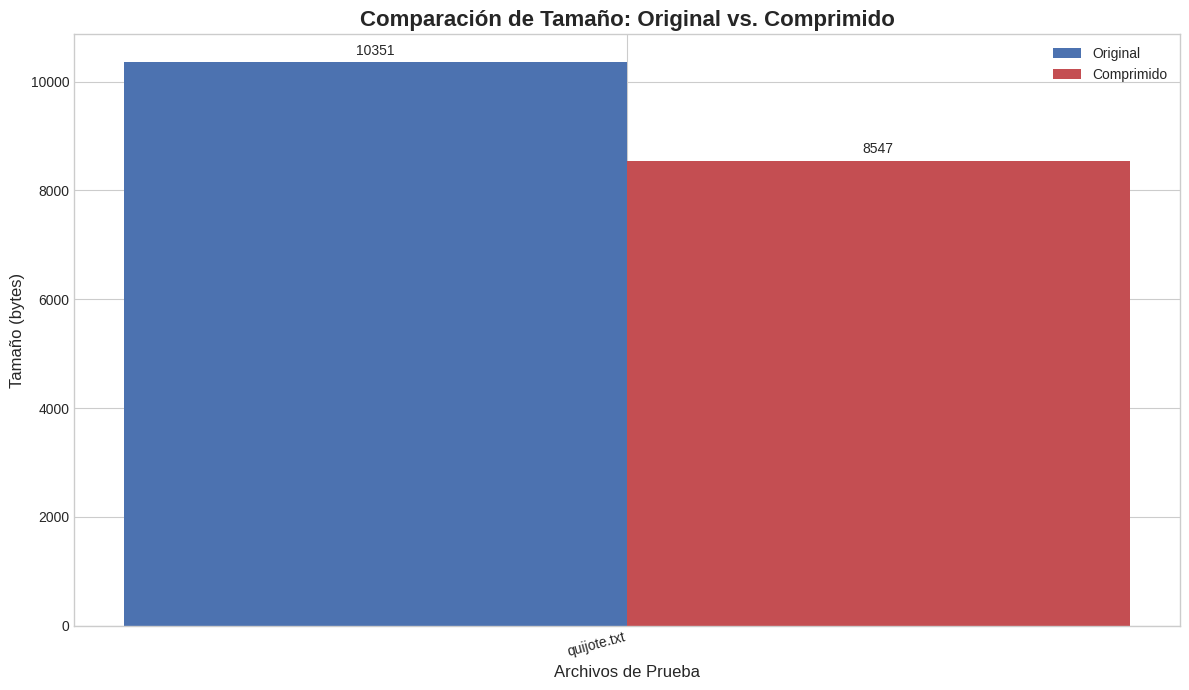

Gráfico guardado en la carpeta /results/


In [48]:
archivos_a_probar = [
        '../data/quijote.txt',
        '../data/texto_repetitivo.txt',
        '../data/texto_aleatorio.txt'
    ]

if __name__ == "__main__":
    results_exp1 = obtener_resultados(archivos_a_probar)
    if results_exp1:
        crear_grafico_comparativo(results_exp1)
        print("Gráfico guardado en la carpeta /results/")
    else:
        print("No hay resultados que mostrar")